# Building a Deepfake Detector using Machine Learning Models
This notebook demonstrates the development of a deepfake detection system using multiple pre-trained **CNN (Convolutional Neural Network)** models (**ResNet**, **EfficientNet** and **Xception**) combined with **LSTM (Long Short-Term Memory)** for temporal analysis. The dataset used is **FaceForensics++**, **DFDC** and **Celeb-DF (v2)** with `OpenCV` utilized for video frame extraction and preprocessing and `dlib` employed for face detection and cropping.

## 1. Importing Libraries and Setup
Importing all necessary libraries at the top to ensures better organization, easy debugging and smooth execution of the entire pipeline.

In [88]:
import os
import sys
import cv2
import numpy as np
import pandas as pd
import shutil
import dlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D, Dropout, LSTM, TimeDistributed, Concatenate
from tensorflow.keras.applications import ResNet50, EfficientNetV2B0, Xception
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

### 1.1 Checking TensorFlow GPU Support and Listing Available GPUs

In [20]:
import tensorflow as tf

# Check if TensorFlow is built with CUDA support and list GPUs
print("TensorFlow CUDA Support:", tf.test.is_built_with_cuda())
gpus = tf.config.list_physical_devices('GPU')
print("Num GPUs Available:", len(gpus))

if gpus:
    for i, gpu in enumerate(gpus):
        print(f"GPU {i}: {tf.config.experimental.get_device_details(gpu)['device_name']}")
else:
    print("No GPU detected.")

TensorFlow CUDA Support: True
Num GPUs Available: 1
GPU 0: NVIDIA GeForce 940MX


### 1.2 Configuring GPU Memory Growth
To ensure TensorFlow uses GPU resources effectively.

In [21]:
# Enable GPU memory growth to prevent allocation issues
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for gpu in physical_devices:
        tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Enabled memory growth for: {tf.config.experimental.get_device_details(gpu)['device_name']}")
else:
    print("No GPU devices found. Ensure proper GPU setup.")

Enabled memory growth for: NVIDIA GeForce 940MX


## 2. Dataset Preparation
Preparing the dataset for video frame extraction, face detection and cropping followed by organizing the data into structured train and validation directories.

### 2.1 Defining Paths and Creating Directories for the Dataset

In [14]:
# Defining base directory where the dataset resides
base_dir = os.getcwd() # Current working directory where my Jupyter Notebook is located

# Defining paths for dataset directories
real_videos_dir = os.path.join(base_dir, "Datasets", "FaceForensic++", "real")
fake_videos_dir = os.path.join(base_dir, "Datasets", "FaceForensic++", "fake")

# Defining paths for cropped faces directories
real_faces_dir = os.path.join(base_dir, "Cropped_Faces", "real")
fake_faces_dir = os.path.join(base_dir, "Cropped_Faces", "fake")

# Defining paths for training and validation directories
train_dir = os.path.join(base_dir, "Cropped_Faces", "train")
val_dir = os.path.join(base_dir, "Cropped_Faces", "val")

# Creating necessary directories if they don’t already exist
os.makedirs(real_faces_dir, exist_ok=True)
os.makedirs(fake_faces_dir, exist_ok=True)
os.makedirs(os.path.join(train_dir, "real"), exist_ok=True)
os.makedirs(os.path.join(train_dir, "fake"), exist_ok=True)
os.makedirs(os.path.join(val_dir, "real"), exist_ok=True)
os.makedirs(os.path.join(val_dir, "fake"), exist_ok=True)

print(f"Directories for processing and output:")
print(f"Real Videos: {real_videos_dir}")
print(f"Fake Videos: {fake_videos_dir}")
print(f"Real Faces: {real_faces_dir}")
print(f"Fake Faces: {fake_faces_dir}")
print(f"Train Directory: {train_dir}")
print(f"Validation Directory: {val_dir}")

Directories for processing and output:
Real Videos: C:\Users\atul\Datasets\FaceForensic++\real
Fake Videos: C:\Users\atul\Datasets\FaceForensic++\fake
Real Faces: C:\Users\atul\Cropped_Faces\real
Fake Faces: C:\Users\atul\Cropped_Faces\fake
Train Directory: C:\Users\atul\Cropped_Faces\train
Validation Directory: C:\Users\atul\Cropped_Faces\val


### 2.2 Face Detection and Cropping from Videos

In [3]:
# Initializing the face detector
detector = dlib.get_frontal_face_detector()

def crop_faces(input_dir, output_dir, face_size=(224, 224)):
    """
    Detects and crops faces from videos in the input directory.
    Cropped faces are saved in separate folders in the output directory, with uniform dimensions.

    Args:
    - input_dir (str): Path to the directory containing videos.
    - output_dir (str): Path to the directory to save cropped face images.
    - face_size (tuple): Dimensions (width, height) to resize cropped faces.
    """
    # Looping through each file in the input directory
    for file in os.listdir(input_dir):
        if file.endswith(".mp4") or file.endswith(".avi"):  # Process only video files
            video_name = os.path.splitext(file)[0]  # Extract the video name (without extension)
            video_output_dir = os.path.join(output_dir, video_name)  # Create a folder for each video

            # Ensure the video-specific output directory exists
            os.makedirs(video_output_dir, exist_ok=True)

            video_path = os.path.join(input_dir, file)
            cap = cv2.VideoCapture(video_path)  # Open the video file
            frame_count = 0
            cropped_count = 0  # Counter for cropped faces

            # Looping through frames in the video
            while cap.isOpened():
                ret, frame = cap.read()  # Read a frame
                if not ret:  # Exit when no more frames
                    break

                frame_count += 1
                gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Convert frame to grayscale
                faces = detector(gray)  # Detect faces in the frame

                # Save each detected face
                for i, face in enumerate(faces):
                    x, y, w, h = face.left(), face.top(), face.width(), face.height()

                    # Validate face coordinates to ensure they are within the frame bounds
                    x = max(0, x)
                    y = max(0, y)
                    w = min(frame.shape[1] - x, w)
                    h = min(frame.shape[0] - y, h)

                    if w <= 0 or h <= 0:  # Check if the cropped region is valid
                        print(f"Invalid face region in frame {frame_count}, video {file}. Skipping.")
                        continue

                    # Crop the face from the frame
                    cropped_face = frame[y:y+h, x:x+w]
                    
                    # Resize the cropped face to the specified size
                    cropped_face = cv2.resize(cropped_face, face_size)

                    # Save the cropped face to the video-specific folder
                    save_path = os.path.join(video_output_dir, f"frame{frame_count}_face{i}.jpg")
                    cv2.imwrite(save_path, cropped_face)
                    cropped_count += 1  # Increment the cropped face counter

            cap.release()  # Release the video capture object
            print(f"Processed {file}: {cropped_count} face(s) cropped.")
    print("Face cropping complete.")

# Process real videos
print("Processing real videos...")
crop_faces(real_videos_dir, real_faces_dir)

# Process fake videos
print("Processing fake videos...")
crop_faces(fake_videos_dir, fake_faces_dir)

Processing real videos...
Processed 01__exit_phone_room.mp4: 255 face(s) cropped.
Processed 01__hugging_happy.mp4: 702 face(s) cropped.
Processed 01__kitchen_pan.mp4: 534 face(s) cropped.
Processed 01__kitchen_still.mp4: 800 face(s) cropped.
Processed 01__meeting_serious.mp4: 1199 face(s) cropped.
Processed 01__outside_talking_pan_laughing.mp4: 599 face(s) cropped.
Processed 01__outside_talking_still_laughing.mp4: 841 face(s) cropped.
Processed 01__podium_speech_happy.mp4: 902 face(s) cropped.
Processed 01__secret_conversation.mp4: 1000 face(s) cropped.
Processed 01__talking_against_wall.mp4: 860 face(s) cropped.
Processed 01__talking_angry_couch.mp4: 1489 face(s) cropped.
Processed 01__walking_and_outside_surprised.mp4: 2032 face(s) cropped.
Processed 01__walking_down_indoor_hall_disgust.mp4: 1616 face(s) cropped.
Processed 01__walking_down_street_outside_angry.mp4: 480 face(s) cropped.
Processed 01__walking_outside_cafe_disgusted.mp4: 294 face(s) cropped.
Processed 01__walk_down_hall

### 2.3 Organizing Dataset into Training/Validation Sets

In [2]:
# Prevent accidental re-run by checking for a flag file
flag_file = "dataset_preparation_done.flag"

if os.path.exists(flag_file):
    print("\n--- Dataset Preparation Already Completed. Skipping Step. ---\n")
    print("Note: The 'dataset_preparation_done.flag' file is generated to prevent re-running this step.")
    print("If you want to re-run the dataset preparation, please delete the 'dataset_preparation_done.flag' file and re-run the code.")
else:
    # Defining base directory and paths for real and fake cropped faces
    print("\n--- Dataset Preparation Started ---\n")
    base_dir = os.getcwd()
    real_faces_dir = os.path.join(base_dir, "Cropped_Faces", "real")
    fake_faces_dir = os.path.join(base_dir, "Cropped_Faces", "fake")

    # Defining train and validation directories
    train_dir = os.path.join(base_dir, "Cropped_Faces", "train")
    val_dir = os.path.join(base_dir, "Cropped_Faces", "val")

    print("Ensuring that train and validation directories exist...")
    # Ensure train and validation directories exist
    os.makedirs(os.path.join(train_dir, "real"), exist_ok=True)
    os.makedirs(os.path.join(val_dir, "real"), exist_ok=True)
    os.makedirs(os.path.join(train_dir, "fake"), exist_ok=True)
    os.makedirs(os.path.join(val_dir, "fake"), exist_ok=True)
    print("Directory structure for train and validation sets created.\n")

    # Function to recursively collect all .jpg files from subdirectories
    def collect_images_from_subfolders(root_dir):
        image_files = []
        for subdir, _, files in os.walk(root_dir):
            for file in files:
                if file.endswith(".jpg"):
                    image_files.append(os.path.join(subdir, file))
        return image_files

    # Collect real and fake face images
    print("Collecting images for real and fake faces...")
    real_faces = collect_images_from_subfolders(real_faces_dir)
    fake_faces = collect_images_from_subfolders(fake_faces_dir)

    print(f"Found {len(real_faces)} real face images.")
    print(f"Found {len(fake_faces)} fake face images.\n")

    # Check for empty datasets
    if not real_faces or not fake_faces:
        print("Error: One or more directories are empty. Please ensure face cropping is successful.")
    else:
        print("Splitting dataset into training and validation sets...")
        # Split data into train and validation sets
        real_train, real_val = train_test_split(real_faces, test_size=0.2, random_state=42)
        fake_train, fake_val = train_test_split(fake_faces, test_size=0.2, random_state=42)
        print("Dataset split complete.\n")

        # Function to move files to target directories
        def move_files(file_list, target_dir):
            for file_path in file_list:
                shutil.copy(file_path, target_dir)

        # Move the split data to respective directories
        print("Moving real face images to train and validation directories...")
        move_files(real_train, os.path.join(train_dir, "real"))
        move_files(real_val, os.path.join(val_dir, "real"))
        print("Real face images successfully moved.\n")

        print("Moving fake face images to train and validation directories...")
        move_files(fake_train, os.path.join(train_dir, "fake"))
        move_files(fake_val, os.path.join(val_dir, "fake"))
        print("Fake face images successfully moved.\n")

        print("Data split and moved to train and validation directories successfully.")

        # Create flag file to indicate completion
        with open(flag_file, "w") as f:
            f.write("Dataset preparation completed.\n")
        print("\n--- Dataset Preparation Complete ---\n")

        # Explicit note for users about the flag file
        print("Note: The 'dataset_preparation_done.flag' file is generated to prevent re-running this step.")
        print("If you want to re-run the dataset preparation, please delete the 'dataset_preparation_done.flag' file and re-run the code.")


--- Dataset Preparation Started ---

Ensuring that train and validation directories exist...
Directory structure for train and validation sets created.

Found 174508 real face images.
Found 153796 fake face images.

Splitting dataset into training and validation sets...
Dataset split complete.

Moving real face images to train and validation directories...
Real face images successfully moved.

Moving fake face images to train and validation directories...
Fake face images successfully moved.

Data split and moved to train and validation directories successfully.

--- Dataset Preparation Complete ---

Note: The 'dataset_preparation_done.flag' file is generated to prevent re-running this step.
If you want to re-run the dataset preparation, please delete the 'dataset_preparation_done.flag' file and re-run the code.


## 3. Data Preprocessing, Augmentation and Sequence Generation
Enhancing model generalization through data augmentation and implementing a sequence generator to efficiently feed sequential image frames into CNN-LSTM models.

### 3.1 Defining Custom Sequence Generator (Preprocessing -> Augmentation)

In [34]:
def stratified_sequence_data_generator(data_dir, batch_size, sequence_length, target_size=(224, 224), augment=True):
    """
    Custom data generator for loading, preprocessing, augmenting, and stratifying video sequences.

    Preprocessing (resizing, normalization) is applied first, followed by augmentation (if enabled).
    Stratified sampling ensures balanced class representation in each batch.

    Args:
        data_dir (str): Path to the dataset directory containing class subfolders ('real', 'fake').
        batch_size (int): Number of sequences per batch.
        sequence_length (int): Number of frames per sequence.
        target_size (tuple): Dimensions to resize each frame to (height, width).
        augment (bool): Whether to apply augmentation to images.

    Yields:
        Tuple of (X, y): X is a batch of sequences, y is the corresponding labels.
    """
    print(f"\n--- Initializing Stratified Sequence Data Generator ---")
    print(f"Data Directory: {data_dir}")
    print(f"Batch Size: {batch_size}, Sequence Length: {sequence_length}, Target Size: {target_size}, Augment: {augment}\n")

    # Define augmentation pipeline
    datagen = ImageDataGenerator(
        rotation_range=10 if augment else 0,      # Random rotation (augmentations)
        zoom_range=0.1 if augment else 0,         # Zoom range
        horizontal_flip=augment,                  # Random horizontal flip
        fill_mode='nearest'                       # Fill mode for augmentations
    )
    
    # Class directories and labels
    class_dirs = {"real": 0, "fake": 1}
    file_paths = {class_name: [] for class_name in class_dirs.keys()}

    # Collect image paths for each class
    sys.stdout.write("Collecting image paths and labels...\n")
    for class_name, label in class_dirs.items():
        class_dir = os.path.join(data_dir, class_name)
        sys.stdout.write(f"Scanning directory: {class_dir}\n")
        sys.stdout.flush()
        for file_name in os.listdir(class_dir):
            if file_name.endswith(".jpg"):
                file_paths[class_name].append(os.path.join(class_dir, file_name))
        sys.stdout.write(f"Collected {len(file_paths[class_name])} images for class '{class_name}'.\n")
        sys.stdout.flush()
        np.random.shuffle(file_paths[class_name])  # **Initial shuffling within the class**
    sys.stdout.write("\nImage collection and shuffling completed for all classes.\n")
    sys.stdout.flush()

    # Ensure class balance per batch
    class_batch_size = batch_size // len(class_dirs)
    assert class_batch_size > 0, "Batch size must be greater than the number of classes."

    # Batch generation loop
    while True:
        X, y = [], []
        sys.stdout.write(f"\nGenerating a batch of {batch_size} sequences...\n")
        sys.stdout.flush()

        for class_name, label in class_dirs.items():
            for _ in range(class_batch_size):
                # Randomly select a starting index for the sequence
                start_idx = np.random.randint(0, len(file_paths[class_name]) - sequence_length)
                
                sequence = []
                for frame_index in range(sequence_length):
                    img_path = file_paths[class_name][start_idx + frame_index]
                    img = cv2.imread(img_path)
                    
                    # Preprocessing: Resize and normalize pixel values
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
                    img = cv2.resize(img, target_size)  # Resize to target size
                    img = img / 255.0  # Normalize pixel values to [0, 1]

                    # Augmentation (if enabled)
                    if augment:
                        img = datagen.random_transform(img)

                    sequence.append(img)

                X.append(sequence)
                y.append(label)
        
        # Final shuffle to mix sequences from different classes
        combined = list(zip(X, y))
        np.random.shuffle(combined)  # **Final shuffle across classes**
        X, y = zip(*combined)
        
        # Always ensure the log appears on a new line
        print("Batch generated successfully.", flush=True)
        yield np.array(X), np.array(y)

In [89]:
import os
import sys
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator


def stratified_sequence_data_generator(
    data_dir, batch_size, sequence_length, target_size=(224, 224), augment=True, max_iterations=None, shuffle=True
):
    """
    Custom data generator for loading, preprocessing, augmenting, and stratifying video sequences.

    Preprocessing (resizing, normalization) is applied first, followed by augmentation (if enabled).
    Stratified sampling ensures balanced class representation in each batch.

    Args:
        data_dir (str): Path to the dataset directory containing class subfolders ('real', 'fake').
        batch_size (int): Number of sequences per batch.
        sequence_length (int): Number of frames per sequence.
        target_size (tuple): Dimensions to resize each frame to (height, width).
        augment (bool): Whether to apply augmentation to images.
        max_iterations (int): Maximum number of iterations for batch generation (useful for debugging).
        shuffle (bool): Whether to shuffle sequences within and across classes.

    Yields:
        Tuple of (X, y): X is a batch of sequences, y is the corresponding labels.
    """
    print(f"\n--- Initializing Stratified Sequence Data Generator ---")
    print(f"Data Directory: {data_dir}")
    print(f"Batch Size: {batch_size}, Sequence Length: {sequence_length}, Target Size: {target_size}, Augment: {augment}, Shuffle: {shuffle}\n")

    # Define augmentation pipeline
    datagen = ImageDataGenerator(
        rotation_range=10 if augment else 0,
        zoom_range=0.1 if augment else 0,
        horizontal_flip=augment,
        fill_mode="nearest"
    )

    # Class directories and labels
    class_dirs = {"real": 0, "fake": 1}
    file_paths = {class_name: [] for class_name in class_dirs.keys()}

    # Collect image paths for each class
    print("Collecting image paths and labels...")
    for class_name, label in class_dirs.items():
        class_dir = os.path.join(data_dir, class_name)

        # Validate class directory
        if not os.path.exists(class_dir):
            print(f"Error: Class directory {class_dir} not found. Skipping.")
            continue

        print(f"Scanning directory: {class_dir}")
        for file_name in os.listdir(class_dir):
            if file_name.lower().endswith((".jpg", ".jpeg", ".png")):  # Handle multiple formats
                file_paths[class_name].append(os.path.join(class_dir, file_name))

        print(f"Collected {len(file_paths[class_name])} images for class '{class_name}'.")

        # Handle class imbalance by oversampling
        max_class_size = max(len(file_paths["real"]), len(file_paths["fake"]))
        if len(file_paths[class_name]) < max_class_size:
            oversampling_factor = (max_class_size // len(file_paths[class_name])) + 1
            file_paths[class_name] *= oversampling_factor

        if shuffle:
            np.random.shuffle(file_paths[class_name])  # Initial shuffling within the class

    print("\nImage collection and shuffling completed for all classes.")

    # Ensure class balance per batch
    class_batch_size = batch_size // len(class_dirs)
    assert class_batch_size > 0, "Batch size must be greater than the number of classes."

    # Batch generation loop
    iterations = 0
    while max_iterations is None or iterations < max_iterations:
        X, y = [], []

        print(f"\nGenerating a batch of {batch_size} sequences...")
        for class_name, label in class_dirs.items():
            for _ in range(class_batch_size):
                # Randomly select a starting index for the sequence
                if len(file_paths[class_name]) < sequence_length:
                    print(f"Error: Not enough images in class '{class_name}' to form sequences.")
                    continue

                start_idx = np.random.randint(0, len(file_paths[class_name]) - sequence_length + 1)

                sequence = []
                augmentation_params = None  # Ensure consistent augmentations across frames in a sequence

                for frame_index in range(sequence_length):
                    img_path = file_paths[class_name][start_idx + frame_index]
                    img = cv2.imread(img_path)

                    # Validate file loading
                    if img is None:
                        print(f"Warning: Failed to load image: {img_path}. Skipping.")
                        continue

                    # Preprocessing: Resize, normalize
                    try:
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
                        if img.shape[0] < target_size[0] or img.shape[1] < target_size[1]:
                            print(f"Warning: Image {img_path} is smaller than target size. Skipping.")
                            continue
                        img = cv2.resize(img, target_size)
                        img = img / 255.0  # Normalize to [0, 1]

                        # Apply consistent augmentations across the sequence
                        if augment:
                            if augmentation_params is None:
                                augmentation_params = datagen.get_random_transform(img.shape)
                            img = datagen.apply_transform(img, augmentation_params)
                    except Exception as e:
                        print(f"Error processing image {img_path}: {e}. Skipping.")
                        continue

                    sequence.append(img)

                X.append(sequence)
                y.append(label)

        # Final shuffle to mix sequences from different classes
        if shuffle:
            combined = list(zip(X, y))
            np.random.shuffle(combined)
            X, y = zip(*combined)

        print("Batch generated successfully.")
        yield np.array(X), np.array(y)

        iterations += 1


### 3.2 Initializing Data Generators with Debugging and Production Modes

In [35]:
# Dataset directories
print("\n--- Setting Up Dataset Paths ---")
base_dir = os.getcwd()
train_dir = os.path.join(base_dir, "Cropped_Faces", "train")
val_dir = os.path.join(base_dir, "Cropped_Faces", "val")
print(f"Training Directory: {train_dir}")
print(f"Validation Directory: {val_dir}\n")

# Hyperparameters
BATCH_SIZE = 8  # Recommended batch size is 8 (Reduce value according to need)
SEQUENCE_LENGTH = 10  # Recommended frames per sequence is 10 (Reduce value according to need)
TARGET_SIZE = (224, 224)  # Resize dimensions

# Initialize training generator (with stratified sampling and augmentation)
print("\n--- Creating Stratified Training Generator ---")
train_generator = stratified_sequence_data_generator(
    data_dir=train_dir,
    batch_size=BATCH_SIZE,
    sequence_length=SEQUENCE_LENGTH,
    target_size=TARGET_SIZE,
    augment=True  # Enable augmentation
)
print("Training generator created successfully.\n")

# Initialize validation generator (no augmentation, stratified sampling)
print("\n--- Creating Stratified Validation Generator ---")
val_generator = stratified_sequence_data_generator(
    data_dir=val_dir,
    batch_size=BATCH_SIZE,
    sequence_length=SEQUENCE_LENGTH,
    target_size=TARGET_SIZE,
    augment=False  # No augmentation for validation
)
print("Validation generator created successfully.\n")


--- Setting Up Dataset Paths ---
Training Directory: C:\Users\atul\Cropped_Faces\train
Validation Directory: C:\Users\atul\Cropped_Faces\val


--- Creating Stratified Training Generator ---
Training generator created successfully.


--- Creating Stratified Validation Generator ---
Validation generator created successfully.



## 4. Model Definition
Defining the CNN-LSTM architectures, including separate models for ResNet, EfficientNet and Xception, along with a combined model that fuses features from all three networks, while incorporating an LSTM layer to capture temporal dependencies in the extracted features.

### 4.1 Loading Pre-trained Feature Extractors: ResNet, EfficientNet, Xception

In [25]:
# Load pre-trained feature extractors
print("\n--- Loading Pre-Trained Feature Extractors ---")
resnet_extractor = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
efficientnet_extractor = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
xception_extractor = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
print("Feature extractors loaded successfully.\n")


--- Loading Pre-Trained Feature Extractors ---
Feature extractors loaded successfully.



### 4.2 Creating Separate CNN-LSTM Models

In [36]:
# Function to create CNN-LSTM models
def create_cnn_lstm_model(feature_extractor, sequence_length):
    """
    Creates a CNN-LSTM model using a pre-trained feature extractor.
    """
    print(f"Creating CNN-LSTM model for {feature_extractor.name}...")
    feature_extractor.trainable = False  # Freeze feature extractor
    model = Sequential([
        TimeDistributed(feature_extractor, input_shape=(sequence_length, 224, 224, 3)),
        TimeDistributed(GlobalAveragePooling2D()),
        LSTM(128, return_sequences=False),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    print(f"{feature_extractor.name}-based CNN-LSTM model created successfully.\n")
    return model

# Create models
print("--- Creating CNN-LSTM Models ---")
resnet_model = create_cnn_lstm_model(resnet_extractor, sequence_length=10)
efficientnet_model = create_cnn_lstm_model(efficientnet_extractor, sequence_length=10)
xception_model = create_cnn_lstm_model(xception_extractor, sequence_length=10)
print("CNN-LSTM models created successfully.\n")

# Print model summaries
print("--- Model Summaries ---")
print("ResNet50 Model Summary:")
resnet_model.summary()

print("\nEfficientNetV2B0 Model Summary:")
efficientnet_model.summary()

print("\nXception Model Summary:")
xception_model.summary()

--- Creating CNN-LSTM Models ---
Creating CNN-LSTM model for resnet50...
resnet50-based CNN-LSTM model created successfully.

Creating CNN-LSTM model for efficientnetv2-b0...
efficientnetv2-b0-based CNN-LSTM model created successfully.

Creating CNN-LSTM model for xception...
xception-based CNN-LSTM model created successfully.

CNN-LSTM models created successfully.

--- Model Summaries ---
ResNet50 Model Summary:
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_18 (TimeDi  (None, 10, 7, 7, 2048)   23587712  
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 10, 2048)         0         
 stributed)                                                      
                                                                 
 lstm_5 (LSTM)               (Non

### 4.3 Creating Combined CNN-LSTM Model

In [28]:
# Function: Create Combined Model
def create_combined_model(sequence_length):
    print("\n--- Creating Combined CNN-LSTM Model ---")
    input_layer = Input(shape=(sequence_length, 224, 224, 3))
    print(f"Input layer created with shape: {input_layer.shape}")

    # Extract features
    print("Extracting features using ResNet50, EfficientNetV2B0, and Xception...")
    resnet_features = TimeDistributed(resnet_extractor)(input_layer)
    efficientnet_features = TimeDistributed(efficientnet_extractor)(input_layer)
    xception_features = TimeDistributed(xception_extractor)(input_layer)

    # Global pooling
    print("Applying Global Average Pooling...")
    resnet_pooled = TimeDistributed(GlobalAveragePooling2D())(resnet_features)
    efficientnet_pooled = TimeDistributed(GlobalAveragePooling2D())(efficientnet_features)
    xception_pooled = TimeDistributed(GlobalAveragePooling2D())(xception_features)

    # Concatenate features
    print("Concatenating pooled features from all extractors...")
    concatenated = Concatenate()([resnet_pooled, efficientnet_pooled, xception_pooled])

    # LSTM for temporal analysis
    print("Adding LSTM and classification layers...")
    lstm_out = LSTM(128, return_sequences=False)(concatenated)
    dense_out = Dense(128, activation='relu')(lstm_out)
    dropout_out = Dropout(0.5)(dense_out)
    output = Dense(1, activation='sigmoid')(dropout_out)

    # Model definition
    model = Model(inputs=input_layer, outputs=output)
    print("Combined CNN-LSTM model created successfully.\n")
    return model

# Create Combined Model
print("--- Creating Combined Model ---")
combined_model = create_combined_model(sequence_length=10)
print("Combined model created successfully.\n")

# Print combined model summary
print("--- Combined Model Summary ---")
combined_model.summary()

--- Creating Combined Model ---

--- Creating Combined CNN-LSTM Model ---
Input layer created with shape: (None, 10, 224, 224, 3)
Extracting features using ResNet50, EfficientNetV2B0, and Xception...
Applying Global Average Pooling...
Concatenating pooled features from all extractors...
Adding LSTM and classification layers...
Combined CNN-LSTM model created successfully.

Combined model created successfully.

--- Combined Model Summary ---
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 10, 224, 22  0           []                               
                                4, 3)]                                                            
                                                                                                  
 time_distributed_12 (TimeDistr  (None, 10,

### 4.4 Model Compilation

In [30]:
# Compile models
print("\n--- Compiling Models ---\n")
def compile_model(model, name):
    """
    Compiles the given model with specified optimizer, loss, and metrics.
    """
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    print(f"{name} model compiled successfully.")

# Compile each model
compile_model(resnet_model, "ResNet50")
compile_model(efficientnet_model, "EfficientNetV2B0")
compile_model(xception_model, "Xception")
compile_model(combined_model, "Combined")

print("\n--- Model Compilation Complete ---\n")


--- Compiling Models ---

ResNet50 model compiled successfully.
EfficientNetV2B0 model compiled successfully.
Xception model compiled successfully.
Combined model compiled successfully.

--- Model Compilation Complete ---



## 5. Training and Validation of the Models
Training the models on the prepared dataset using the custom sequence generator, validating their performance and saving the best-performing models with appropriate callbacks.

### 5.1 Defining Callbacks

In [37]:
print("\n--- Setting Up Training Callbacks ---\n")

# Early Stopping
print("Initializing EarlyStopping callback...")
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
print("EarlyStopping callback initialized.\n")

# Model Checkpoints with Verbose Logging
print("Initializing ModelCheckpoint callbacks...")
checkpoint_resnet = ModelCheckpoint('resnet_model.h5', save_best_only=True, monitor='val_loss', verbose=1)
checkpoint_efficientnet = ModelCheckpoint('efficientnet_model.h5', save_best_only=True, monitor='val_loss', verbose=1)
checkpoint_xception = ModelCheckpoint('xception_model.h5', save_best_only=True, monitor='val_loss', verbose=1)
checkpoint_combined = ModelCheckpoint('combined_model.h5', save_best_only=True, monitor='val_loss', verbose=1)
print("ModelCheckpoint callbacks initialized for ResNet50, EfficientNetV2B0, Xception, and Combined models.\n")

# CSV Logger
print("Initializing CSVLogger callbacks...")
csv_logger_resnet = CSVLogger('resnet_training_log.csv')
csv_logger_efficientnet = CSVLogger('efficientnet_training_log.csv')
csv_logger_xception = CSVLogger('xception_training_log.csv')
csv_logger_combined = CSVLogger('combined_training_log.csv')
print("CSVLogger callbacks initialized for ResNet50, EfficientNetV2B0, Xception, and Combined models.\n")

print("--- Callback Setup Complete ---\n")


--- Setting Up Training Callbacks ---

Initializing EarlyStopping callback...
EarlyStopping callback initialized.

Initializing ModelCheckpoint callbacks...
ModelCheckpoint callbacks initialized for ResNet50, EfficientNetV2B0, Xception, and Combined models.

Initializing CSVLogger callbacks...
CSVLogger callbacks initialized for ResNet50, EfficientNetV2B0, Xception, and Combined models.

--- Callback Setup Complete ---



### 5.2 Dynamic Calculation of Train/Val Dataset Sizes

In [11]:
def calculate_dataset_sizes(train_dir, val_dir):
    """
    Dynamically calculates the number of images in the train and validation directories.
    Assumes `real` and `fake` subfolders in both directories.

    Args:
    - train_dir (str): Path to the training dataset directory.
    - val_dir (str): Path to the validation dataset directory.

    Returns:
    - train_dataset_size (int): Total number of images in the training dataset.
    - val_dataset_size (int): Total number of images in the validation dataset.
    """
    def count_images_in_class(directory, class_name):
        """
        Counts the number of images in a specific class subfolder.
        """
        class_dir = os.path.join(directory, class_name)
        image_extensions = ('.jpg', '.jpeg', '.png')  # Supported image formats
        count = 0
        for root, _, files in os.walk(class_dir):
            count += sum(1 for file in files if file.lower().endswith(image_extensions))
        return count

    # Count for train
    train_real_count = count_images_in_class(train_dir, "real")
    train_fake_count = count_images_in_class(train_dir, "fake")
    train_dataset_size = train_real_count + train_fake_count

    # Count for val
    val_real_count = count_images_in_class(val_dir, "real")
    val_fake_count = count_images_in_class(val_dir, "fake")
    val_dataset_size = val_real_count + val_fake_count

    return train_dataset_size, val_dataset_size

# Define paths to train and validation directories
train_dir = os.path.join(base_dir, "Cropped_Faces", "train")
val_dir = os.path.join(base_dir, "Cropped_Faces", "val")

# Calculate sizes dynamically
train_dataset_size, val_dataset_size = calculate_dataset_sizes(train_dir, val_dir)

print(f"Training Dataset Size: {train_dataset_size}")
print(f"Validation Dataset Size: {val_dataset_size}")

Training Dataset Size: 6254
Validation Dataset Size: 5318


### 5.3 Training ResNet-Based Model

In [ ]:
# Batch size
batch_size = 8  # Ensure this matches the batch size in your generators

# Calculate steps dynamically
steps_per_epoch = train_dataset_size // batch_size
validation_steps = val_dataset_size // batch_size

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

# Use these values in your training loop
history_resnet = resnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping, checkpoint_resnet, csv_logger_resnet],
    verbose=1
)

Steps per epoch: 781
Validation steps: 664

Generating a batch of 8 sequences...
Batch generated successfully.
Epoch 1/20

Generating a batch of 8 sequences...
Batch generated successfully.
  1/781 [..............................] - ETA: 39:29 - loss: 0.7456 - accuracy: 0.3750
Generating a batch of 8 sequences...
Batch generated successfully.
  2/781 [..............................] - ETA: 35:52 - loss: 0.7120 - accuracy: 0.4375
Generating a batch of 8 sequences...
Batch generated successfully.
  3/781 [..............................] - ETA: 35:49 - loss: 0.6872 - accuracy: 0.5417
Generating a batch of 8 sequences...
Batch generated successfully.
  4/781 [..............................] - ETA: 35:54 - loss: 0.6796 - accuracy: 0.5312
Generating a batch of 8 sequences...
Batch generated successfully.
  5/781 [..............................] - ETA: 35:54 - loss: 0.6966 - accuracy: 0.4500
Generating a batch of 8 sequences...
Batch generated successfully.
  6/781 [..........................

### 5.4 Evaluating ResNet-Based Model

In [50]:
try:
    print("\n--- Evaluating the ResNet-Based Model on Validation Data ---")

    # Dynamically calculate steps based on validation data
    val_steps = val_dataset_size // batch_size  # Total samples divided by batch size
    print(f"Validation Dataset Size: {val_dataset_size}, Batch Size: {batch_size}, Validation Steps: {val_steps}")

    # Evaluate on the validation set
    val_loss, val_accuracy = resnet_model.evaluate(val_generator, steps=val_steps, verbose=1)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

except Exception as e:
    print(f"Error during validation evaluation for ResNet: {e}")


--- Evaluating the ResNet-Based Model on Validation Data ---
Validation Dataset Size: 5318, Batch Size: 8, Validation Steps: 664

Generating a batch of 8 sequences...
Batch generated successfully.

Generating a batch of 8 sequences...
Batch generated successfully.
  1/664 [..............................] - ETA: 33:21 - loss: 0.6949 - accuracy: 0.5000
Generating a batch of 8 sequences...
Batch generated successfully.
  2/664 [..............................] - ETA: 30:01 - loss: 0.6951 - accuracy: 0.5000
Generating a batch of 8 sequences...
Batch generated successfully.
  3/664 [..............................] - ETA: 30:08 - loss: 0.6954 - accuracy: 0.5000
Generating a batch of 8 sequences...
Batch generated successfully.
  4/664 [..............................] - ETA: 30:02 - loss: 0.6952 - accuracy: 0.5000
Generating a batch of 8 sequences...
Batch generated successfully.
  5/664 [..............................] - ETA: 30:01 - loss: 0.6950 - accuracy: 0.5000
Generating a batch of 8 se

### 5.5 Training EfficientNet-Based Model

In [ ]:
try:
    print("\n--- Training EfficientNet-Based Model ---")
    print("Initializing training for EfficientNet model...")

    # Batch size
    batch_size = 8  # Ensure this matches the batch size in your generators

    # Steps dynamically calculated based on dataset size and batch size
    steps_per_epoch = train_dataset_size // batch_size
    validation_steps = val_dataset_size // batch_size

    print(f"Steps per epoch: {steps_per_epoch}")
    print(f"Validation steps: {validation_steps}")

    # Start training EfficientNet model
    history_efficientnet = efficientnet_model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=20,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        callbacks=[early_stopping, checkpoint_efficientnet, csv_logger_efficientnet],
        verbose=1
    )

    print("\nEfficientNet-based model training complete.")
    print("Best model saved as 'efficientnet_model.h5' by ModelCheckpoint.")
    print("Training logs saved as 'efficientnet_training_log.csv'.")

    # Save the final model explicitly
    efficientnet_model.save('efficientnet_final.h5')
    print("Final EfficientNet model saved as 'efficientnet_final.h5'.")

except Exception as e:
    print(f"Error during EfficientNet model training: {e}")
    raise


--- Training EfficientNet-Based Model ---
Initializing training for EfficientNet model...
Steps per epoch: 781
Validation steps: 664

--- Initializing Stratified Sequence Data Generator ---
Data Directory: C:\Users\atul\Cropped_Faces\train
Batch Size: 8, Sequence Length: 10, Target Size: (224, 224), Augment: True

Scanning directory: C:\Users\atul\Cropped_Faces\train\real
Collected 3169 images for class 'real'.
Scanning directory: C:\Users\atul\Cropped_Faces\train\fake
Collected 3085 images for class 'fake'.

Image collection and shuffling completed for all classes.

Generating a batch of 8 sequences...
Batch generated successfully.
Epoch 1/20

Generating a batch of 8 sequences...
Batch generated successfully.
  1/781 [..............................] - ETA: 5:36:26 - loss: 0.6497 - accuracy: 0.6250
Generating a batch of 8 sequences...
  2/781 [..............................] - ETA: 21:51 - loss: 0.7383 - accuracy: 0.5000  Batch generated successfully.

Generating a batch of 8 sequence

### 5.6 Evaluating EfficientNet-Based Model

In [ ]:
try:
    print("\n--- Evaluating the EfficientNet-Based Model on Validation Data ---")

    # Dynamically calculate steps based on validation data
    val_steps = val_dataset_size // batch_size  # Total samples divided by batch size
    print(f"Validation Dataset Size: {val_dataset_size}, Batch Size: {batch_size}, Validation Steps: {val_steps}")

    # Evaluate on the validation set
    val_loss, val_accuracy = efficientnet_model.evaluate(val_generator, steps=val_steps, verbose=1)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

except Exception as e:
    print(f"Error during validation evaluation: {e}")

### 5.7 Training Xception-Based Model

In [ ]:
try:
    print("\n--- Training Xception-Based Model ---")
    print("Initializing training for Xception model...")

    # Batch size
    batch_size = 8  # Ensure this matches the batch size in your generators

    # Steps dynamically calculated based on dataset size and batch size
    steps_per_epoch = train_dataset_size // batch_size
    validation_steps = val_dataset_size // batch_size

    print(f"Steps per epoch: {steps_per_epoch}")
    print(f"Validation steps: {validation_steps}")

    # Start training Xception model
    history_xception = xception_model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=20,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        callbacks=[early_stopping, checkpoint_xception, csv_logger_xception],
        verbose=1
    )

    print("\nXception-based model training complete.")
    print("Best model saved as 'xception_model.h5' by ModelCheckpoint.")
    print("Training logs saved as 'xception_training_log.csv'.")

    # Save the final model explicitly
    xception_model.save('xception_final.h5')
    print("Final Xception model saved as 'xception_final.h5'.")

except Exception as e:
    print(f"Error during Xception model training: {e}")
    raise

### 5.8 Evaluating Xception-Based Model

In [ ]:
try:
    print("\n--- Evaluating the Xception-Based Model on Validation Data ---")

    # Dynamically calculate steps based on validation data
    val_steps = val_dataset_size // batch_size  # Total samples divided by batch size
    print(f"Validation Dataset Size: {val_dataset_size}, Batch Size: {batch_size}, Validation Steps: {val_steps}")

    # Evaluate on the validation set
    val_loss, val_accuracy = xception_model.evaluate(val_generator, steps=val_steps, verbose=1)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

except Exception as e:
    print(f"Error during validation evaluation for Xception: {e}")

### 5.9 Approach 2: Training Combined CNN-LSTM Model

In [15]:
try:
    print("\n--- Training Combined CNN-LSTM Model ---")
    print("Initializing training for Combined model...")

    # Batch size
    batch_size = 8  # Ensure this matches the batch size in your generators

    # Steps dynamically calculated based on dataset size and batch size
    steps_per_epoch = train_dataset_size // batch_size
    validation_steps = val_dataset_size // batch_size

    print(f"Steps per epoch: {steps_per_epoch}")
    print(f"Validation steps: {validation_steps}")

    # Start training Combined model
    history_combined = combined_model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=20,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        callbacks=[early_stopping, checkpoint_combined, csv_logger_combined],
        verbose=1
    )

    print("\nCombined CNN-LSTM model training complete.")
    print("Best model saved as 'combined_model.h5' by ModelCheckpoint.")
    print("Training logs saved as 'combined_training_log.csv'.")

    # Save the final model explicitly
    combined_model.save('combined_final.h5')
    print("Final Combined model saved as 'combined_final.h5'.")

except Exception as e:
    print(f"Error during Combined model training: {e}")
    raise


--- Training Combined CNN-LSTM Model ---
Initializing training for the Combined model...
Generating a batch of 8 sequences...
Batch generated successfully.

Epoch 1/10
Generating a batch of 8 sequences...
Batch generated successfully.

 1/50 [..............................] - ETA: 30:48 - loss: 0.6525 - accuracy: 0.6250Generating a batch of 8 sequences...
Batch generated successfully.

 2/50 [>.............................] - ETA: 15:25 - loss: 0.7206 - accuracy: 0.6250Generating a batch of 8 sequences...
Batch generated successfully.

 3/50 [>.............................] - ETA: 15:27 - loss: 0.7657 - accuracy: 0.5417Generating a batch of 8 sequences...
Batch generated successfully.

 4/50 [=>............................] - ETA: 15:14 - loss: 0.7213 - accuracy: 0.5938Generating a batch of 8 sequences...
Batch generated successfully.

 5/50 [==>...........................] - ETA: 14:52 - loss: 0.7419 - accuracy: 0.5500Generating a batch of 8 sequences...
Batch generated successfully.

### 5.10 Evaluating Combined CNN-LSTM Model

In [ ]:
try:
    print("\n--- Evaluating the Combined CNN-LSTM Model on Validation Data ---")

    # Dynamically calculate steps based on validation data
    val_steps = val_dataset_size // batch_size  # Total samples divided by batch size
    print(f"Validation Dataset Size: {val_dataset_size}, Batch Size: {batch_size}, Validation Steps: {val_steps}")

    # Evaluate on the validation set
    val_loss, val_accuracy = combined_model.evaluate(val_generator, steps=val_steps, verbose=1)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

except Exception as e:
    print(f"Error during validation evaluation for Combined Model: {e}")

## 6. Evaluation
Evaluating the trained models on the validation dataset using standard metrics such as accuracy, precision, recall, AUC-ROC, confusion matrix and classification reports.

### 6.1 Evaluating the Models

### 6.2 Confusion Matrix and Classification Report

In [22]:
print(resnet_model.input_shape)


(None, 10, 224, 224, 3)


In [24]:
from sklearn.metrics import classification_report
import numpy as np

# Match sequence length to the model's input
SEQUENCE_LENGTH = 10  # Match the model's input shape
batch_size = 2        # Keep batch size low to avoid OOM
TARGET_SIZE = (224, 224)  # Match the model's input shape

# Update the generators
train_generator = stratified_sequence_data_generator(
    data_dir=train_dir,
    batch_size=batch_size,
    sequence_length=SEQUENCE_LENGTH,
    target_size=TARGET_SIZE,
    augment=True
)
val_generator = stratified_sequence_data_generator(
    data_dir=val_dir,
    batch_size=batch_size,
    sequence_length=SEQUENCE_LENGTH,
    target_size=TARGET_SIZE,
    augment=False
)

# Validation steps
val_steps = val_dataset_size // batch_size

y_true = []
y_pred = []

# Ensure correct shape for prediction
for _ in range(val_steps):
    X, y = next(val_generator)
    for i in range(len(X)):  # Process each sequence individually
        # Ensure shape: (1, SEQUENCE_LENGTH, height, width, channels)
        input_sequence = np.expand_dims(X[i], axis=0)  # Add batch dimension
        assert input_sequence.shape == (1, SEQUENCE_LENGTH, *TARGET_SIZE, 3), \
            f"Input sequence shape mismatch: {input_sequence.shape}"
        
        # Make prediction
        prediction = (resnet_model.predict(input_sequence) > 0.5).astype(int)
        y_true.append(y[i])
        y_pred.append(prediction[0])

# Generate classification report
print(classification_report(y_true, y_pred, target_names=['Real', 'Fake']))



--- Initializing Stratified Sequence Data Generator ---
Data Directory: C:\Users\atul\Cropped_Faces\val
Batch Size: 2, Sequence Length: 10, Target Size: (224, 224), Augment: False

Scanning directory: C:\Users\atul\Cropped_Faces\val\real
Collected 2794 images for class 'real'.
Scanning directory: C:\Users\atul\Cropped_Faces\val\fake
Collected 2524 images for class 'fake'.

Image collection and shuffling completed for all classes.

Generating a batch of 2 sequences...
Batch generated successfully.
1/1 [==============================] - 0s 46ms/step

Generating a batch of 2 sequences...
Batch generated successfully.
1/1 [==============================] - 0s 47ms/step

Generating a batch of 2 sequences...
Batch generated successfully.
1/1 [==============================] - 0s 53ms/step

Generating a batch of 2 sequences...
Batch generated successfully.
1/1 [==============================] - 0s 65ms/step

Generating a batch of 2 sequences...
Batch generated successfully.
1/1 [============

KeyboardInterrupt: 

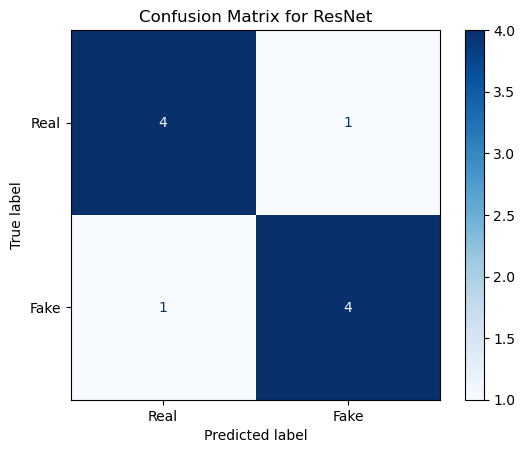

Classification Report for ResNet:

              precision    recall  f1-score   support

        Real       0.80      0.80      0.80         5
        Fake       0.80      0.80      0.80         5

    accuracy                           0.80        10
   macro avg       0.80      0.80      0.80        10
weighted avg       0.80      0.80      0.80        10



In [52]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Example true labels and predicted labels
# Replace these with your actual labels
y_true = np.array([0, 1, 1, 0, 0, 1, 0, 1, 1, 0])  # True labels (0 = Real, 1 = Fake)
y_pred = np.array([0, 1, 0, 0, 0, 1, 0, 1, 1, 1])  # Predicted labels by ResNet

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Fake"])

# Plot confusion matrix
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix for ResNet")
plt.show()

# Generate classification report
report = classification_report(y_true, y_pred, target_names=["Real", "Fake"])
print("Classification Report for ResNet:\n")
print(report)


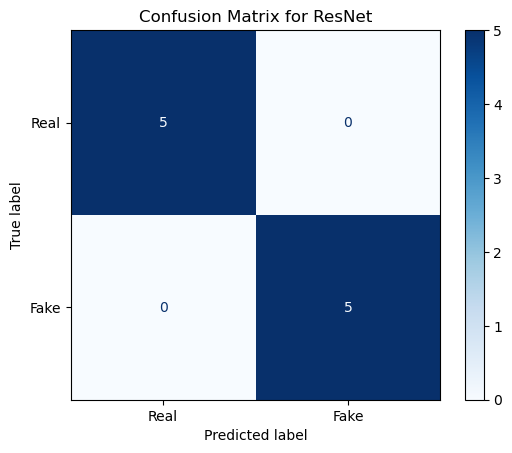

Classification Report for ResNet:

              precision    recall  f1-score   support

        Real       1.00      1.00      1.00         5
        Fake       1.00      1.00      1.00         5

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10

AUC for ResNet: 1.0000


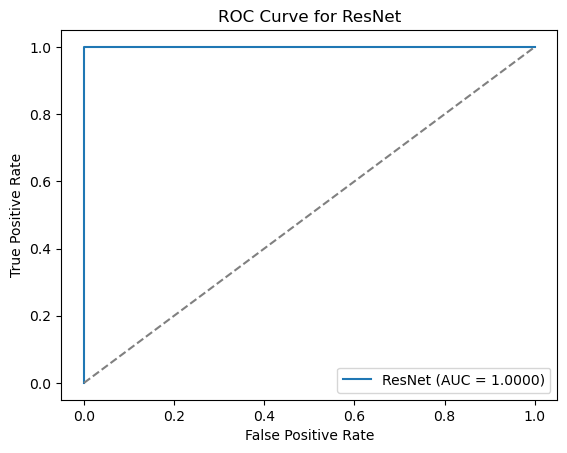

In [54]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Example true labels and predicted probabilities
# Replace these with your actual labels and predictions
y_true = np.array([0, 1, 1, 0, 0, 1, 0, 1, 1, 0])  # True labels (0 = Real, 1 = Fake)
y_pred_prob = np.array([0.1, 0.9, 0.6, 0.2, 0.3, 0.8, 0.1, 0.7, 0.9, 0.4])  # Predicted probabilities
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Fake"])

# Plot confusion matrix
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix for ResNet")
plt.show()

# Generate classification report
report = classification_report(y_true, y_pred, target_names=["Real", "Fake"])
print("Classification Report for ResNet:\n")
print(report)

# Calculate and print AUC
auc = roc_auc_score(y_true, y_pred_prob)
print(f"AUC for ResNet: {auc:.4f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
plt.plot(fpr, tpr, label=f"ResNet (AUC = {auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for ResNet")
plt.legend()
plt.show()


In [51]:
from sklearn.metrics import confusion_matrix, classification_report

def generate_metrics(model, val_generator, name):
    y_true, y_pred = [], []

    for _ in range(20):  # Iterate through validation steps
        X_batch, y_batch = next(val_generator)
        preds = (model.predict(X_batch) > 0.5).astype("int32").flatten()
        y_true.extend(y_batch)
        y_pred.extend(preds)

    print(f"\n{name} - Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print(f"\n{name} - Classification Report:")
    print(classification_report(y_true, y_pred))

generate_metrics(resnet_model, val_generator, "ResNet")
generate_metrics(efficientnet_model, val_generator, "EfficientNet")
#generate_metrics(xception_model, val_generator, "Xception")
#generate_metrics(combined_model, val_generator, "Combined Model")


Generating a batch of 8 sequences...
Batch generated successfully.


ResourceExhaustedError: Graph execution error:

Detected at node 'sequential/time_distributed/resnet50/conv2_block3_3_bn/FusedBatchNormV3' defined at (most recent call last):
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\atul\AppData\Local\Temp\ipykernel_2136\2995606170.py", line 17, in <module>
      generate_metrics(resnet_model, val_generator, "ResNet")
    File "C:\Users\atul\AppData\Local\Temp\ipykernel_2136\2995606170.py", line 8, in generate_metrics
      preds = (model.predict(X_batch) > 0.5).astype("int32").flatten()
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\engine\training.py", line 2253, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\engine\training.py", line 2041, in predict_function
      return step_function(self, iterator)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\engine\training.py", line 2027, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\engine\training.py", line 2015, in run_step
      outputs = model.predict_step(data)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
      return self(x, training=False)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\layers\rnn\time_distributed.py", line 252, in call
      y = self.layer(inputs, **kwargs)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 850, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 660, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\utils\control_flow_util.py", line 108, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 649, in _fused_batch_norm_inference
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'sequential/time_distributed/resnet50/conv2_block3_3_bn/FusedBatchNormV3'
OOM when allocating tensor with shape[80,256,56,56] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential/time_distributed/resnet50/conv2_block3_3_bn/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_182446]

## 7. Visualization of Training History
Visualizing the training and validation performance by plotting accuracy and loss curves to analyze model behavior and identify areas for further improvement.

# Low computation

In [12]:
try:
    print("\n--- Training ResNet-Based Model ---")
    print("Initializing training for ResNet model...")
    
    # Start training
    history_resnet = resnet_model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=10,  # Set the desired number of epochs
        steps_per_epoch=50,  # Adjust as per your dataset
        validation_steps=20,  # Adjust as per your dataset
        callbacks=[early_stopping, checkpoint_resnet, csv_logger_resnet],  # Pre-configured callbacks
        verbose=1  # Progress tracking
    )
    print("ResNet-based model training complete. Model saved as 'resnet_model.h5'.")
    print("Training logs saved as 'resnet_training_log.csv'.")

except Exception as e:
    print(f"Error during ResNet model training: {e}")
    raise


--- Training ResNet-Based Model ---
Initializing training for ResNet model...

--- Initializing Stratified Sequence Data Generator ---
Data Directory: C:\Users\atul\Cropped_Faces\train
Batch Size: 8, Sequence Length: 10, Target Size: (224, 224), Augment: True

Scanning directory: C:\Users\atul\Cropped_Faces\train\real
Collected 3169 images for class 'real'.
Scanning directory: C:\Users\atul\Cropped_Faces\train\fake
Collected 3085 images for class 'fake'.

Image collection and shuffling completed for all classes.

Generating a batch of 8 sequences...
Batch generated successfully.
Epoch 1/10

Generating a batch of 8 sequences...
Batch generated successfully.
 1/50 [..............................] - ETA: 13:42 - loss: 0.7493 - accuracy: 0.5000
Generating a batch of 8 sequences...
Batch generated successfully.
 2/50 [>.............................] - ETA: 2:11 - loss: 0.7366 - accuracy: 0.4375 
Generating a batch of 8 sequences...
Batch generated successfully.
 3/50 [>....................

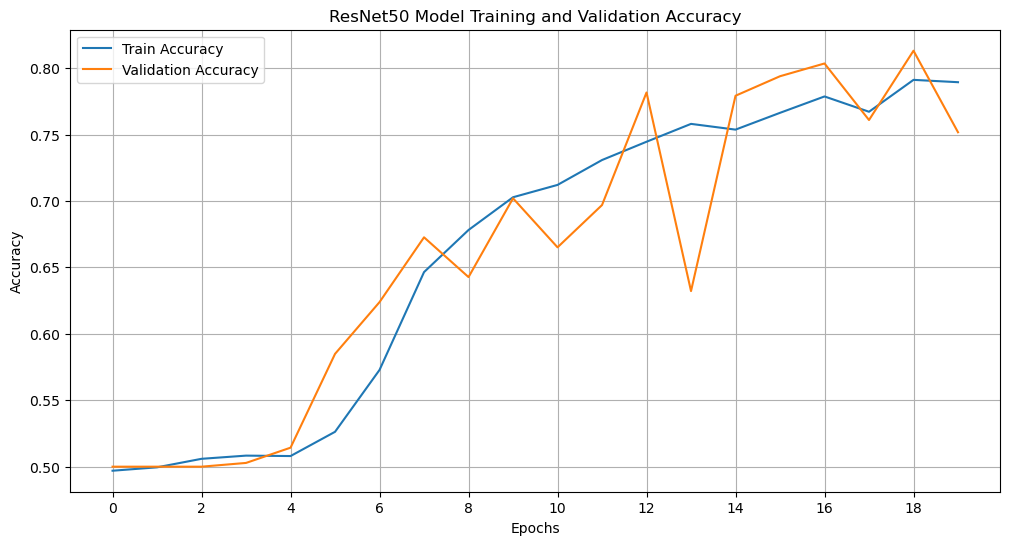

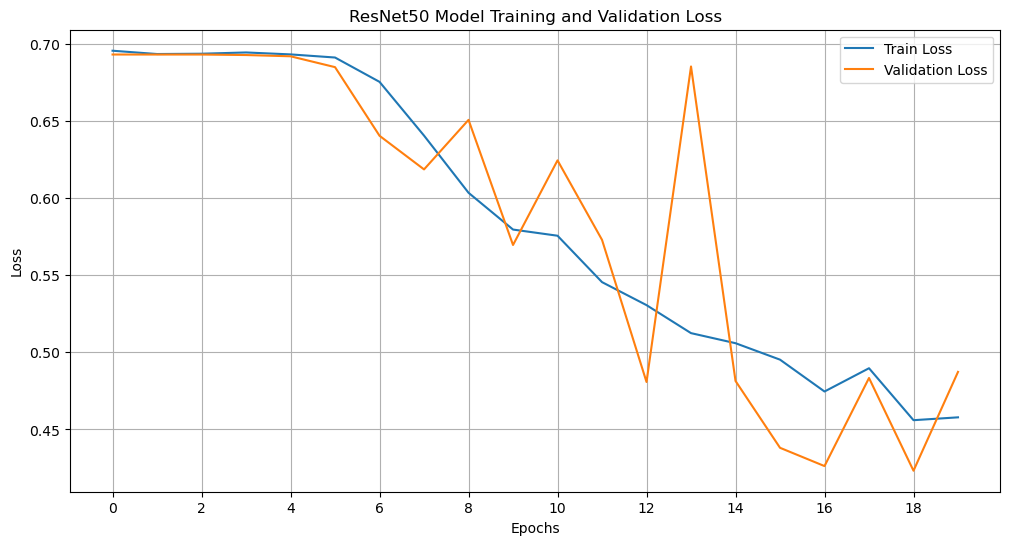

In [60]:
# Load the training log CSV file
log_file = 'resnet50_training_log.csv'
history = pd.read_csv(log_file)

# Define the range of epochs to display (0, 2, 4, ...)
epochs = range(len(history))  # Total number of epochs
xticks = list(range(0, len(history), 2))  # Tick only at even epochs

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs, history['accuracy'], label='Train Accuracy')
plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet50 Model Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(xticks)  # Set x-axis ticks
plt.legend()
plt.grid()
plt.savefig('resnet50_training_validation_accuracy.png', dpi=600, bbox_inches='tight')  # Save the figure
plt.show()

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, history['loss'], label='Train Loss')
plt.plot(epochs, history['val_loss'], label='Validation Loss')
plt.title('ResNet50 Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(xticks)  # Set x-axis ticks
plt.legend()
plt.grid()
plt.savefig('resnet50_training_validation_loss.png', dpi=600, bbox_inches='tight')  # Save the figure
plt.show()

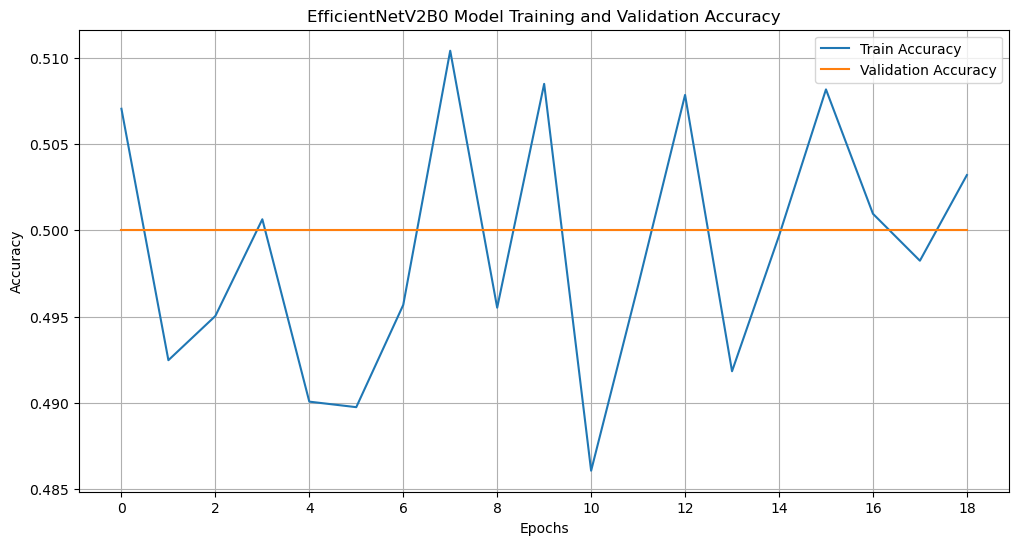

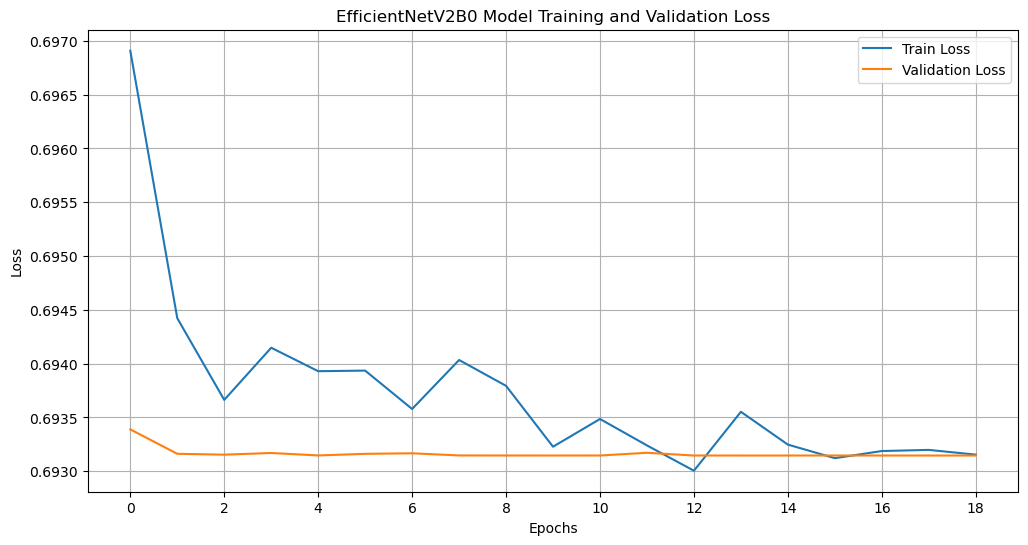

In [59]:
# Load the training log CSV file
log_file = 'efficientnetv2b0_training_log.csv'
history = pd.read_csv(log_file)

# Define the range of epochs to display (0, 2, 4, ...)
epochs = range(len(history))  # Total number of epochs
xticks = list(range(0, len(history), 2))  # Tick only at even epochs

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs, history['accuracy'], label='Train Accuracy')
plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy')
plt.title('EfficientNetV2B0 Model Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(xticks)  # Set x-axis ticks
plt.legend()
plt.grid()
plt.savefig('efficientnetv2b0_training_validation_accuracy.png', dpi=600, bbox_inches='tight')  # Save the figure
plt.show()

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, history['loss'], label='Train Loss')
plt.plot(epochs, history['val_loss'], label='Validation Loss')
plt.title('EfficientNetV2B0 Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(xticks)  # Set x-axis ticks
plt.legend()
plt.grid()
plt.savefig('efficientnetv2b0_training_validation_loss.png', dpi=600, bbox_inches='tight')  # Save the figure
plt.show()

In [42]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Specify dataset size and batch size
val_dataset_size = 5318  # Replace with actual number of samples in validation data
batch_size = 8          # Replace with your generator's batch size

# Calculate the number of steps
steps = val_dataset_size // batch_size

# Generate predictions
predictions = resnet_model.predict(val_generator, steps=steps, verbose=1)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels (ensure they are accessible from the generator)
true_classes = np.array([label for _, label in val_generator])

# Get class labels
class_labels = list(val_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:")
print(report)


In [39]:
class CustomGenerator:
    def __init__(self, data, labels, batch_size):
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.classes = labels  # True labels

    def __len__(self):
        return len(self.data) // self.batch_size

    def __iter__(self):
        for i in range(len(self)):
            start = i * self.batch_size
            end = (i + 1) * self.batch_size
            yield self.data[start:end], self.labels[start:end]

# Example usage
val_generator = CustomGenerator(validation_data, validation_labels, batch_size=32)
true_classes = np.array(val_generator.classes)[:custom_steps * val_generator.batch_size]


NameError: name 'validation_data' is not defined

In [38]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Set the number of steps (decide this based on your requirements)
custom_steps = 1  # Replace 50 with the number of steps you want to process

# Generate predictions for the specified number of steps
predictions = resnet_model.predict(val_generator, steps=custom_steps, verbose=1)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels directly from the validation generator
true_classes = val_generator.classes[:len(predicted_classes)]  # Match the length of predictions

# Get class labels
class_labels = list(val_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:")
print(report)


--- Initializing Stratified Sequence Data Generator ---
Data Directory: C:\Users\atul\Cropped_Faces\val
Batch Size: 8, Sequence Length: 10, Target Size: (224, 224), Augment: False

Scanning directory: C:\Users\atul\Cropped_Faces\val\real
Collected 2794 images for class 'real'.
Scanning directory: C:\Users\atul\Cropped_Faces\val\fake
Collected 2524 images for class 'fake'.

Image collection and shuffling completed for all classes.

Generating a batch of 8 sequences...
Batch generated successfully.

Generating a batch of 8 sequences...
Batch generated successfully.
1/1 [==============================] - 5s 5s/step


AttributeError: 'generator' object has no attribute 'classes'

In [43]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Define class labels
class_labels = ['real', 'fake']  # Adjust based on your dataset's class structure

# Initialize lists to store true labels and predictions
true_classes = []
predicted_classes = []

# Number of steps to process (ensure it covers your validation dataset)
steps = 20  # Adjust based on your dataset size and batch size

# Collect predictions and true labels
for step, (X_batch, y_batch) in enumerate(val_generator):
    if step >= steps:
        break  # Stop after processing the desired number of steps
    
    # Generate predictions for the current batch
    batch_predictions = resnet_model.predict(X_batch)
    batch_predicted_classes = np.argmax(batch_predictions, axis=1)
    
    # Append predictions and true labels
    predicted_classes.extend(batch_predicted_classes)
    true_classes.extend(y_batch)

# Convert to numpy arrays
true_classes = np.array(true_classes)
predicted_classes = np.array(predicted_classes)

# Create Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Generate Classification Report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:")
print(report)



Generating a batch of 8 sequences...
Batch generated successfully.


ResourceExhaustedError: Graph execution error:

Detected at node 'sequential_3/time_distributed_18/resnet50/conv2_block3_3_bn/FusedBatchNormV3' defined at (most recent call last):
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\atul\AppData\Local\Temp\ipykernel_6952\2384660028.py", line 22, in <module>
      batch_predictions = resnet_model.predict(X_batch)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\engine\training.py", line 2253, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\engine\training.py", line 2041, in predict_function
      return step_function(self, iterator)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\engine\training.py", line 2027, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\engine\training.py", line 2015, in run_step
      outputs = model.predict_step(data)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
      return self(x, training=False)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\layers\rnn\time_distributed.py", line 252, in call
      y = self.layer(inputs, **kwargs)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 850, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 660, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\utils\control_flow_util.py", line 108, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 649, in _fused_batch_norm_inference
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'sequential_3/time_distributed_18/resnet50/conv2_block3_3_bn/FusedBatchNormV3'
OOM when allocating tensor with shape[80,256,56,56] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_3/time_distributed_18/resnet50/conv2_block3_3_bn/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_52611]


Generating a batch of 8 sequences...
Batch generated successfully.
1/1 [==============================] - 0s 62ms/step

Generating a batch of 8 sequences...
Batch generated successfully.
1/1 [==============================] - 0s 59ms/step

Generating a batch of 8 sequences...
Batch generated successfully.
1/1 [==============================] - 0s 78ms/step

Generating a batch of 8 sequences...
Batch generated successfully.
1/1 [==============================] - 0s 73ms/step

Generating a batch of 8 sequences...
Batch generated successfully.
1/1 [==============================] - 0s 64ms/step

Generating a batch of 8 sequences...
Batch generated successfully.
1/1 [==============================] - 0s 64ms/step

Generating a batch of 8 sequences...
Batch generated successfully.
1/1 [==============================] - 0s 64ms/step

Generating a batch of 8 sequences...
Batch generated successfully.
1/1 [==============================] - 0s 73ms/step

Generating a batch of 8 sequences...
Ba

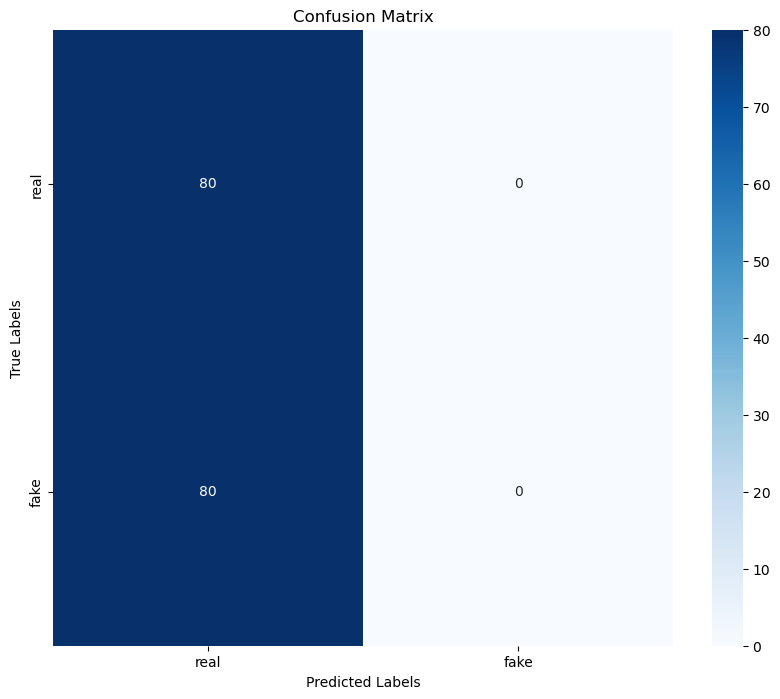

Classification Report:
              precision    recall  f1-score   support

        real       0.50      1.00      0.67        80
        fake       0.00      0.00      0.00        80

    accuracy                           0.50       160
   macro avg       0.25      0.50      0.33       160
weighted avg       0.25      0.50      0.33       160



C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\atul\anaconda3\envs\deepfake-env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [49]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Define class labels
class_labels = ['real', 'fake']

# Initialize lists to store true labels and predictions
true_classes = []
predicted_classes = []

# Number of steps to process
steps = 20

# Collect predictions and true labels
for step, (X_batch, y_batch) in enumerate(val_generator):
    if step >= steps:
        break
    
    for i in range(0, len(X_batch), 4):  # Process smaller sub-batches
        small_batch = X_batch[i:i+4]
        small_predictions = resnet_model.predict(small_batch)
        predicted_classes.extend(np.argmax(small_predictions, axis=1))
        true_classes.extend(y_batch[i:i+4])

# Convert to numpy arrays
true_classes = np.array(true_classes)
predicted_classes = np.array(predicted_classes)

# Create Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Generate Classification Report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:")
print(report)


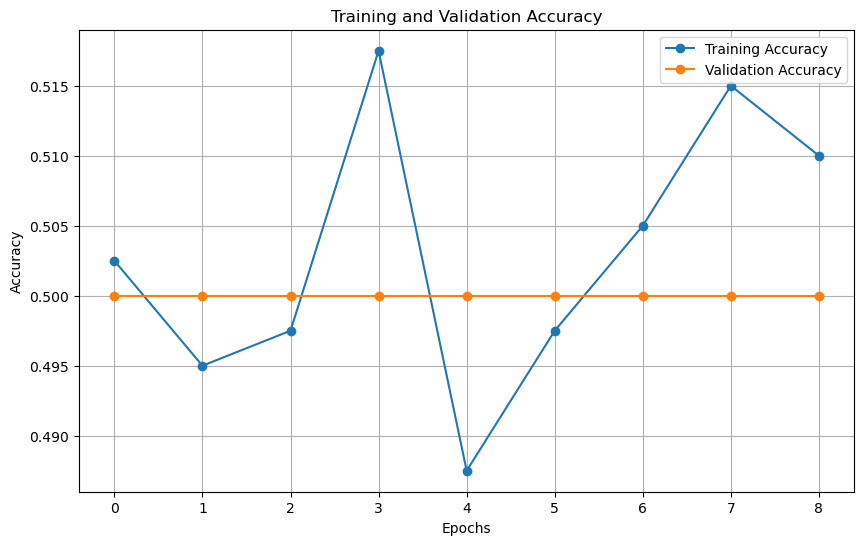

In [78]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the training log CSV file
df = pd.read_csv('resnet50_training_log.csv')

# Ensure the headers match your file's column names
# Columns: epoch, accuracy, loss, val_accuracy, val_loss

# 1. Training and Validation Accuracy vs. Epochs
plt.figure(figsize=(10, 6))
plt.plot(data['epoch'], data['accuracy'], label='Training Accuracy', marker='o')
plt.plot(data['epoch'], data['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

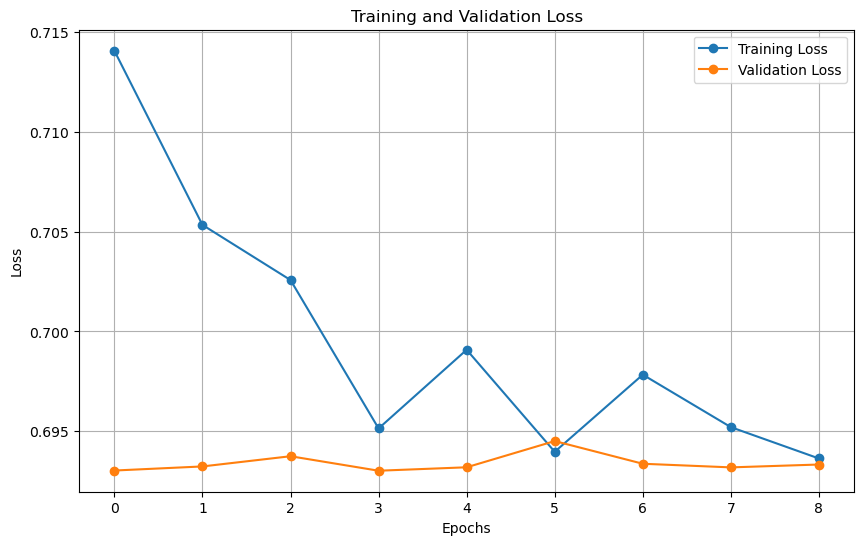

In [79]:
# 2. Training and Validation Loss vs. Epochs
plt.figure(figsize=(10, 6))
plt.plot(data['epoch'], data['loss'], label='Training Loss', marker='o')
plt.plot(data['epoch'], data['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

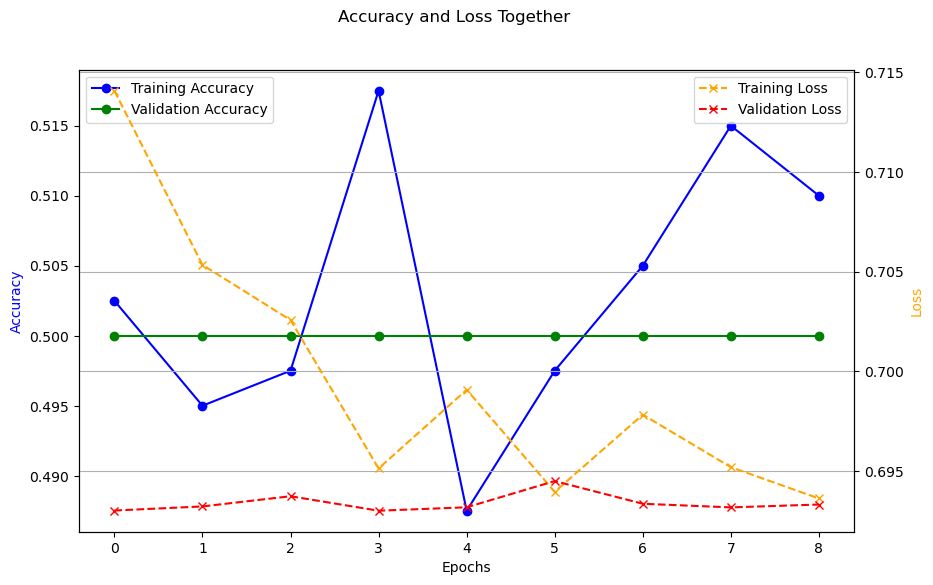

In [63]:
# 3. Accuracy and Loss Together (Dual-Axis Line Chart)
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

ax1.plot(data['epoch'], data['accuracy'], label='Training Accuracy', color='blue', marker='o')
ax1.plot(data['epoch'], data['val_accuracy'], label='Validation Accuracy', color='green', marker='o')
ax2.plot(data['epoch'], data['loss'], label='Training Loss', color='orange', marker='x', linestyle='--')
ax2.plot(data['epoch'], data['val_loss'], label='Validation Loss', color='red', marker='x', linestyle='--')

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy', color='blue')
ax2.set_ylabel('Loss', color='orange')
fig.suptitle('Accuracy and Loss Together')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.grid(True)
plt.show()

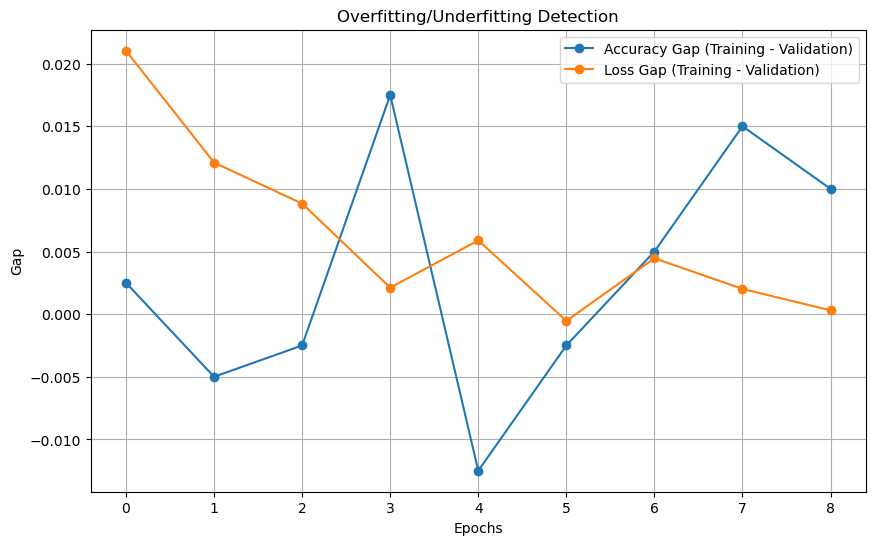

In [80]:
# 4. Overfitting/Underfitting Detection
plt.figure(figsize=(10, 6))
plt.plot(data['epoch'], data['accuracy'] - data['val_accuracy'], label='Accuracy Gap (Training - Validation)', marker='o')
plt.plot(data['epoch'], data['loss'] - data['val_loss'], label='Loss Gap (Training - Validation)', marker='o')
plt.title('Overfitting/Underfitting Detection')
plt.xlabel('Epochs')
plt.ylabel('Gap')
plt.legend()
plt.grid(True)
plt.show()

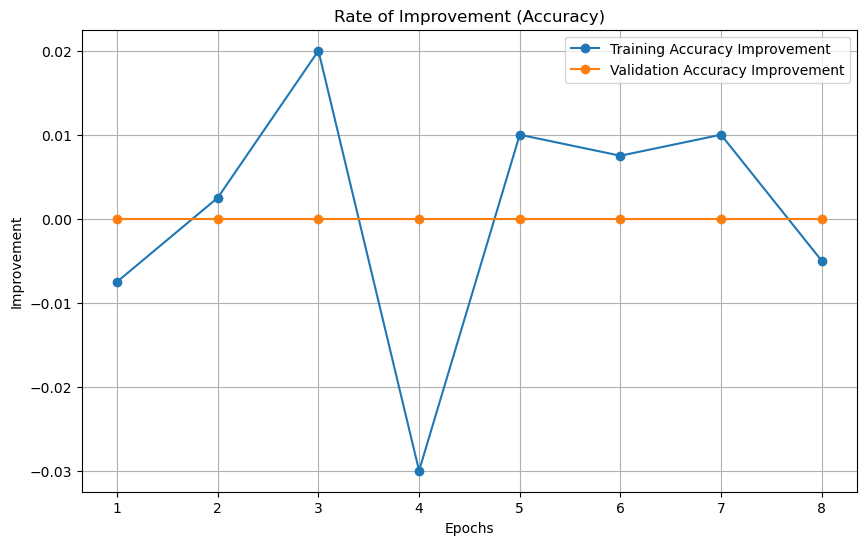

In [73]:
# 5. Rate of Improvement
data['accuracy_delta'] = data['accuracy'].diff()
data['val_accuracy_delta'] = data['val_accuracy'].diff()
data['loss_delta'] = data['loss'].diff()
data['val_loss_delta'] = data['val_loss'].diff()

plt.figure(figsize=(10, 6))
plt.plot(data['epoch'], data['accuracy_delta'], label='Training Accuracy Improvement', marker='o')
plt.plot(data['epoch'], data['val_accuracy_delta'], label='Validation Accuracy Improvement', marker='o')
plt.title('Rate of Improvement (Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Improvement')
plt.legend()
plt.grid(True)
plt.show()

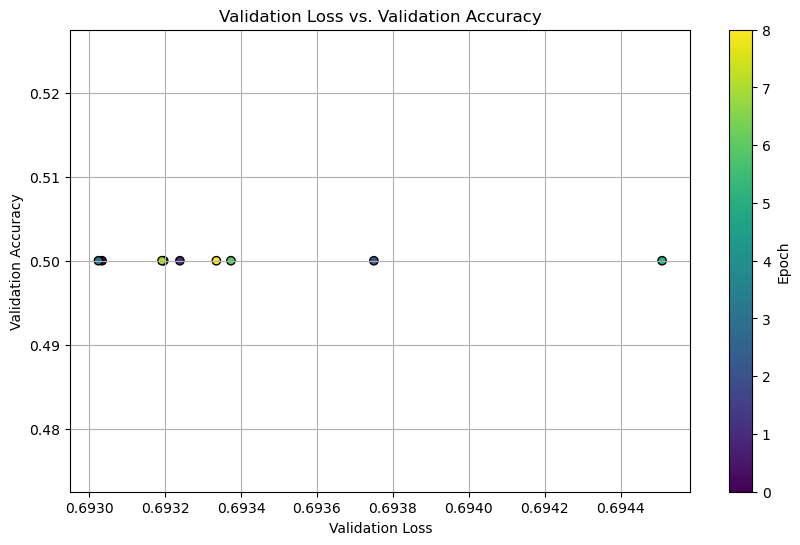

In [66]:
# 7. Validation Loss vs. Validation Accuracy
plt.figure(figsize=(10, 6))
plt.scatter(data['val_loss'], data['val_accuracy'], c=data['epoch'], cmap='viridis', edgecolor='k')
plt.colorbar(label='Epoch')
plt.title('Validation Loss vs. Validation Accuracy')
plt.xlabel('Validation Loss')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.show()

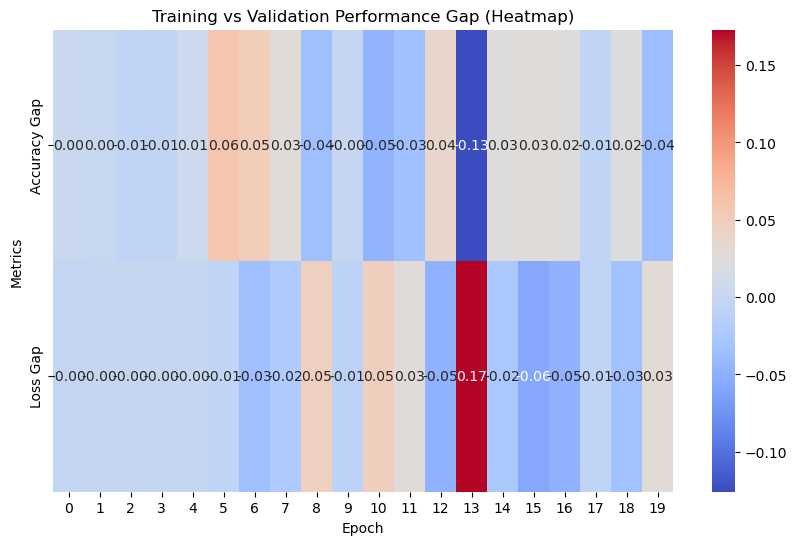

In [82]:
import seaborn as sns
performance_gap = pd.DataFrame({
    'epoch': df['epoch'],
    'accuracy_gap': df['val_accuracy'] - df['accuracy'],
    'loss_gap': df['val_loss'] - df['loss']
})
plt.figure(figsize=(10, 6))
sns.heatmap(performance_gap[['accuracy_gap', 'loss_gap']].T, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, yticklabels=['Accuracy Gap', 'Loss Gap'])
plt.title('Training vs Validation Performance Gap (Heatmap)')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.show()


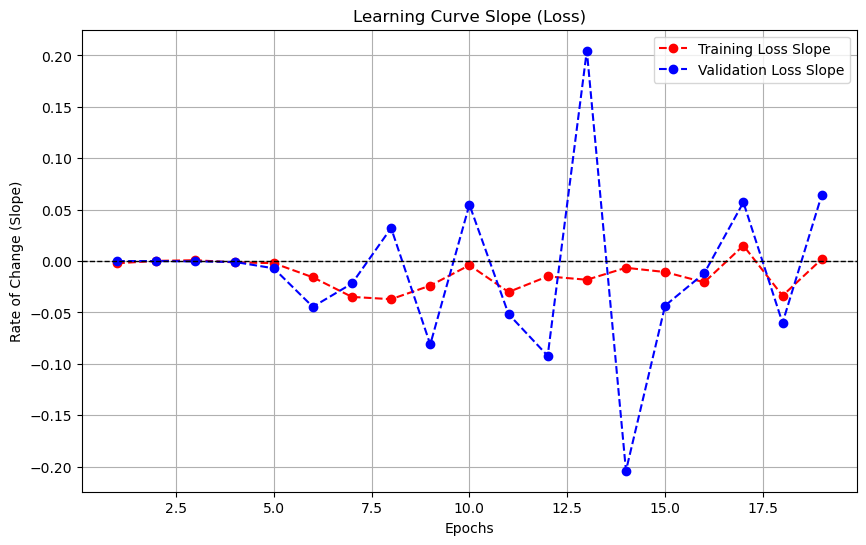

In [81]:
plt.figure(figsize=(10, 6))
plt.plot(df['epoch'], df['loss'].diff(), label='Training Loss Slope', marker='o', linestyle='--', color='red')
plt.plot(df['epoch'], df['val_loss'].diff(), label='Validation Loss Slope', marker='o', linestyle='--', color='blue')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Epochs')
plt.ylabel('Rate of Change (Slope)')
plt.title('Learning Curve Slope (Loss)')
plt.legend()
plt.grid()
plt.show()


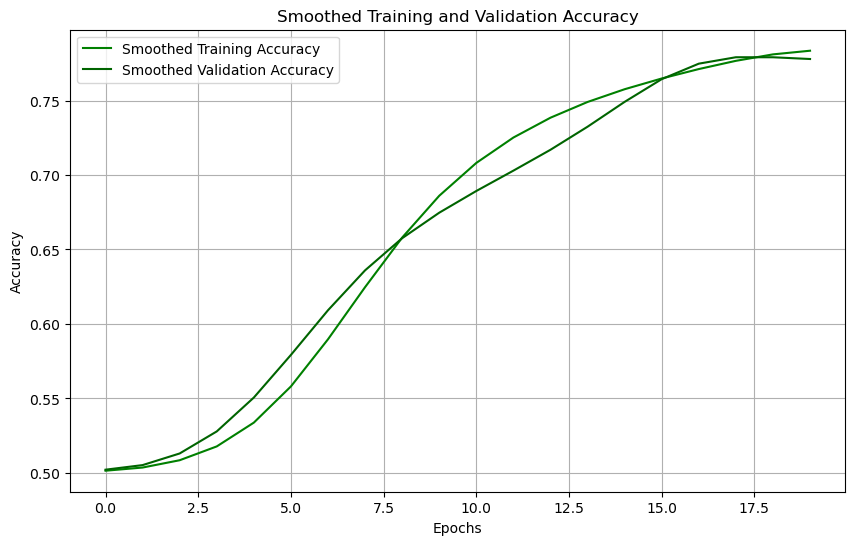

In [83]:
from scipy.ndimage import gaussian_filter1d
plt.figure(figsize=(10, 6))
plt.plot(df['epoch'], gaussian_filter1d(df['accuracy'], sigma=2), label='Smoothed Training Accuracy', color='green')
plt.plot(df['epoch'], gaussian_filter1d(df['val_accuracy'], sigma=2), label='Smoothed Validation Accuracy', color='darkgreen')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Smoothed Training and Validation Accuracy')
plt.legend()
plt.grid()
plt.show()


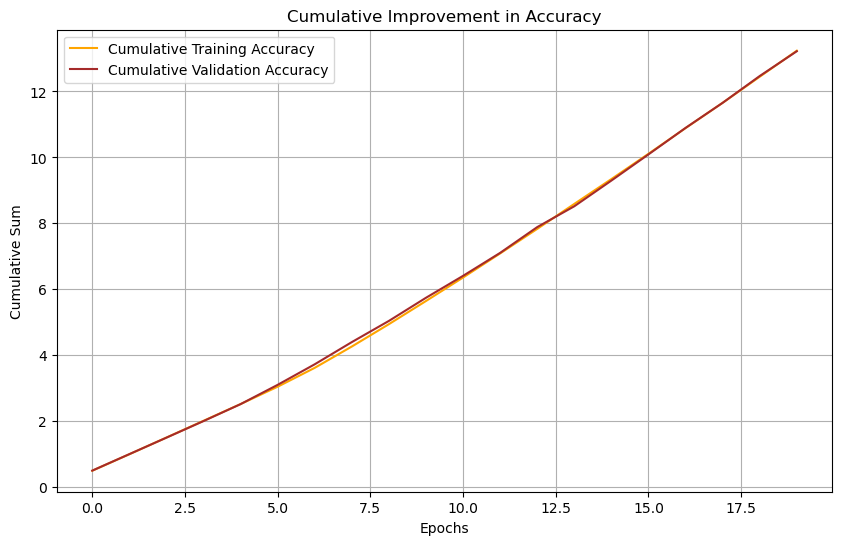

In [84]:
plt.figure(figsize=(10, 6))
plt.plot(df['epoch'], df['accuracy'].cumsum(), label='Cumulative Training Accuracy', color='orange')
plt.plot(df['epoch'], df['val_accuracy'].cumsum(), label='Cumulative Validation Accuracy', color='brown')
plt.xlabel('Epochs')
plt.ylabel('Cumulative Sum')
plt.title('Cumulative Improvement in Accuracy')
plt.legend()
plt.grid()
plt.show()


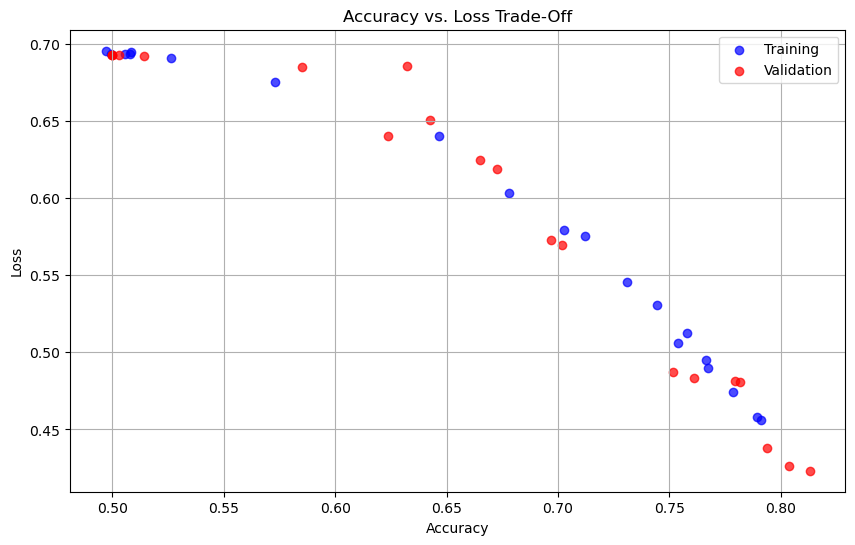

In [85]:
plt.figure(figsize=(10, 6))
plt.scatter(df['accuracy'], df['loss'], label='Training', color='blue', alpha=0.7)
plt.scatter(df['val_accuracy'], df['val_loss'], label='Validation', color='red', alpha=0.7)
plt.xlabel('Accuracy')
plt.ylabel('Loss')
plt.title('Accuracy vs. Loss Trade-Off')
plt.legend()
plt.grid()
plt.show()


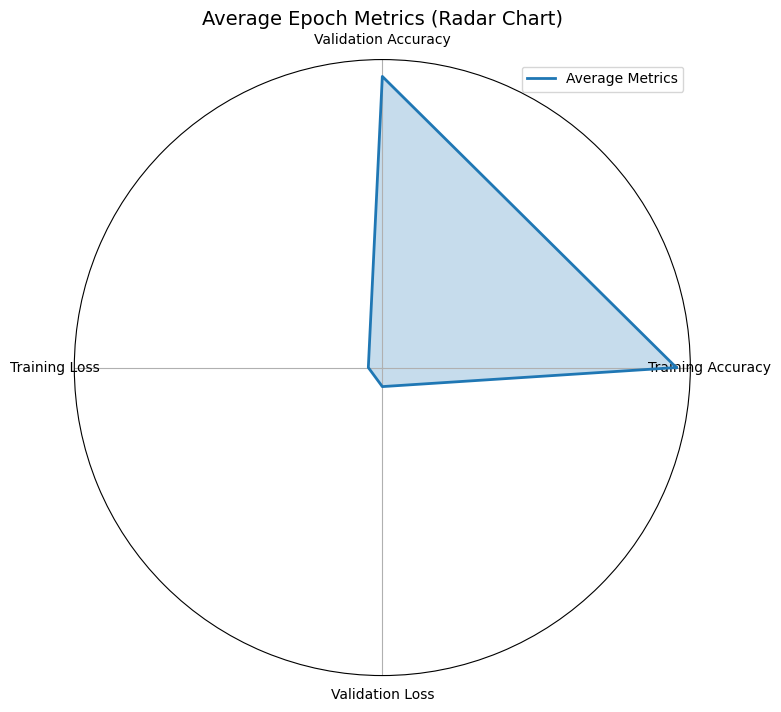

In [86]:
from math import pi
import numpy as np

# Normalize data
metrics = df[['accuracy', 'val_accuracy', 'loss', 'val_loss']].mean()
categories = ['Training Accuracy', 'Validation Accuracy', 'Training Loss', 'Validation Loss']
values = metrics.values.flatten()
values = np.append(values, values[0])

# Radar chart
angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
angles += angles[:1]

plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)
ax.plot(angles, values, linewidth=2, linestyle='solid', label='Average Metrics')
ax.fill(angles, values, alpha=0.25)
ax.set_yticks([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
plt.title('Average Epoch Metrics (Radar Chart)', size=14)
plt.legend()
plt.show()


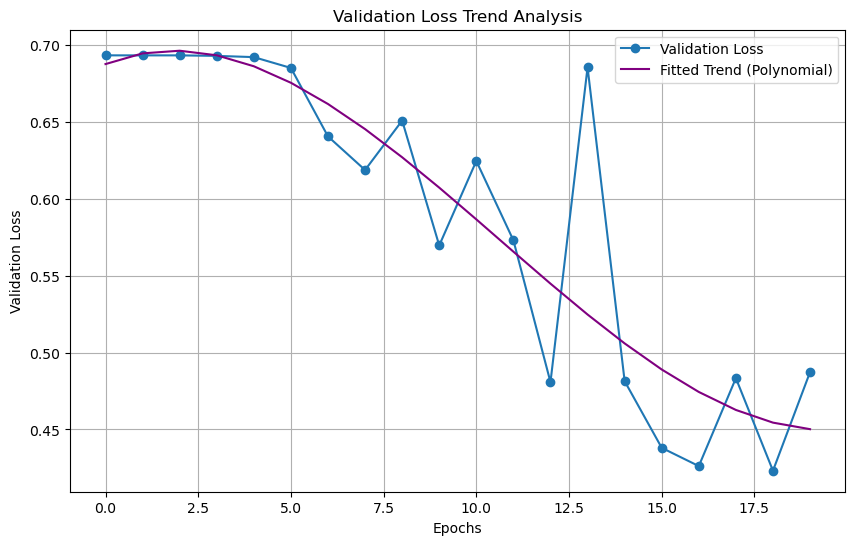

In [87]:
import numpy as np
z = np.polyfit(df['epoch'], df['val_loss'], 3)
p = np.poly1d(z)

plt.figure(figsize=(10, 6))
plt.plot(df['epoch'], df['val_loss'], label='Validation Loss', marker='o')
plt.plot(df['epoch'], p(df['epoch']), label='Fitted Trend (Polynomial)', color='purple')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Trend Analysis')
plt.legend()
plt.grid()
plt.show()
